In [1]:
import os 
import sys 
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
if project_root not in sys.path: 
    sys.path.insert(0, project_root)

print(project_root)

/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce Paper/contrastive-abstraction-RL


In [2]:
import matplotlib.pyplot as plt 
import torch  
import torch.nn.functional as F

import minari 
import numpy as np
import faiss

from sklearn.decomposition import PCA 
from sklearn.preprocessing import normalize

from src.utils.sampling_states import sample_states
from src.utils.remove_dupes import remove_dupes

from src.data.TrajectorySet import TrajectorySet

from src.models.cl_model import mlpCL

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)
faiss.omp_set_num_threads(1)

# Solves a faiss issue with macbooks
sys.modules['faiss.swigfaiss_avx2'] = faiss

In [4]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu"
PROJECT_ROOT = project_root
TOTAL_STATES = 4096

In [5]:
# get laplace model
model_name_1 = "laplace_cos_sim-v1.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/trained_models", model_name_1) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    laplace_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))

Found pretrained model at /Users/ray/Documents/Research Assistancy UofA 2025/Reproduce Paper/contrastive-abstraction-RL/trained_models/laplace_cos_sim-v1.ckpt, loading...


/opt/homebrew/Caskroom/miniforge/base/envs/CL_RL/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.1.post0


In [6]:
def check_norm(x):
    x_norm_check = torch.allclose(x.norm(p=2, dim=-1), torch.ones(x.size(0)), atol=1e-6)
    return x_norm_check

In [ ]:
class cmhn(): 
    def __init__(self, max_iter = 100, threshold = 0.95,topk = 256, use_gpu = False, device="cpu"):
        """
        Continuous Modern Hopfield Network 

        Args: 
            update_steps: The number of iterations the cmhn will do. (Usually just one).
            topk: Using faiss, only the top k most similar patterns will be used. (more efficient in batch-wise updates) 
            use_gpu: Tells faiss if we use faiss-cpu or faiss-gpu for behind the scenes calculations. 
            device: The device that torch will use. 
        """
        self.max_iter = max_iter 
        self.threshold = threshold
        self.topk = topk
        self.use_gpu = use_gpu
        self.device = torch.device(device)
        self.index = None 
        self.convergence_counter = 0 

    def __build_index(self, X, d): 
        """
        Builds a faiss index (an object) for efficient searching of top-k patterns from X. 
        """
        X_np = X.detach().cpu().numpy().astype("float32") # convert X from tensor to numpy 

        if self.use_gpu: 
            flat_index = faiss.IndexFlatL2(d) 
            self.index = faiss.index_cpu_to_all_gpus(flat_index)
        else: 
            self.index = faiss.IndexFlatL2(d)
        
        self.index.add(X_np)
    
    def __update(self, X, xi, beta): 
        """
        The update rule for a continuous modern hopfield network. 

        Args: 
            X: The stored patterns. X is of size [N, d], where N is the number of patterns, and d the size of the patterns. 
            xi: The state pattern (ie. the current pattern being updated). xi is of size [d, 1]. 
            beta: The scalar inverse-temperature hyperparamater. Controls the number of metastable states that occur in the energy landscape. 
                - High beta corresponds to low temp, more separation between patterns.  
                - Low beta corresponds to high temp, less separation (more metastable states). 
        """
        X_norm = F.normalize(X, p=2, dim=1)
        xi_norm = F.normalize(xi, p=2, dim=0)
        sims = X_norm @ xi_norm  # simularity between stored patterns and current pattern 
        p = F.softmax(beta * sims, dim=0, dtype=torch.float32)  # softmax dist along patterns (higher probability => more likely to be that stored pattern)
        # p of size [N, 1] 

        X_T = X_norm.transpose(0, 1) 
        xi_new = X_T @ p  # xi_new, the updated state pattern; size [d, 1]
        return xi_new

    def __run_batch(self, X, queries, beta=None): 
        """
        Runs the mhn batch-wise for efficient computation. 

        Args: 
            X: Stored patterns, size [N, d].
            queries: Input queries, size [N, d].
            beta: The beta value per sample, size [N].
        """        
        
        assert beta != None, "Must have a value for beta." 
        assert X.shape == queries.shape, "X and queries must be the same shape! (N, d)."
        N, d = X.shape 

        # normalize for cos sim calcs
        X_norm = F.normalize(X, p=2, dim=-1)
        queries_norm = F.normalize(queries, p=2, dim=-1)

        self.__build_index(X, d) 

        queries_np = queries_norm.detach().cpu().numpy().astype("float32")
        _, indices = self.index.search(queries_np, self.topk)
        
        queries = torch.from_numpy(queries_np).to(X.device)
        indices = torch.from_numpy(indices).to(X.device) # indices of shape [N, topk]

        topk_X = X_norm[indices] # size [N, topk, d] 
        topk_q = queries.unsqueeze(1) # change queries from [N, d] to [N, 1, d] for broadcasting
        
        # dot product of x_ij * q_i along "d dim" to obtain tensor of [N, topk]
        # q_i represents the i'th query
        # x_ij represents the corresponding i'th query and j'th pattern, where j is among the topk 
        # then sum over d to obtain the similarity between row i and col j. 
        sims = torch.sum(topk_X * topk_q, dim=-1) 

        beta = beta.view(-1, 1)  # beta: [N, 1], broadcasting beta. 
        sims = beta * sims       # sims * beta: [N, topk]
        probs = F.softmax(sims, dim=-1) # calculate probs along patterns (NOT queries) ie. along topk --> [N, topk]
        
        # weighted sum over topk_X: x_ij * probs_i
        xi_new = torch.sum(probs.unsqueeze(-1) * topk_X, dim=1)

        return xi_new
    
    def __has_converged(self, old_xi, new_xi): 
        """ 
        Checks whether or not the hopfield network has converged. Convergence is measured through taking the average cosine similarity 
        between old_xi and new_xi. If this average meets the threshold (ie. avg_cos_sim >= threshold), then we say that old_xi and 
        new_xi are the same and that the hopfield network has converged. 

        old_xi and new_xi are shapes: [N, d]

        Args: 
            old_xi xi before running the udpate rule.
            new_xi: xi after running the update rule.
        
        Returns:
            True: if the average cosine similarity between old_xi and new_xi is meets the threshold.
            False: if the average cosine similarity between old_xi and new_xi is below the threshold.
        """
        converged = False 

        old_norm = F.normalize(old_xi, p=2, dim=-1)  # normalize along rows
        new_norm = F.normalize(new_xi, p=2, dim=-1)

        cos_sim = torch.sum(old_norm * new_norm, dim=1)  # [N], similarity for each query

        min_cos_sim = cos_sim.min().item()
        if min_cos_sim >= self.threshold:
            converged = True

        return converged

    def run(self, X, xi, beta=None, run_as_batch=False): 
        """
        Runs the network. 

        Args: 
            X: The stored patterns. X is of size [N, d], where B is the batches, N is the number of patterns, and d the size of the patterns. 
            xi: The state pattern (ie. the current pattern being updated). xi is of size [d, 1]. xi can also be a batch of queries [N, d].
            beta: The scalar inverse-temperature hyperparamater. Controls the number of metastable states that occur in the energy landscape. 
                - High beta corresponds to low temp, more separation between patterns.  
                - Low beta corresponds to high temp, less separation (more metastable states). 
        """
        assert beta != None, "Must have a value for beta."

        if not isinstance(beta, torch.Tensor):
           beta = torch.as_tensor(beta, dtype=torch.float32)

        X = X.to(self.device)
        xi = xi.to(self.device)
        beta = beta.to(self.device)

        if run_as_batch: 
            if xi.dim() == 1: 
                raise ValueError("Query shape should be [N, d] when updating as a batch.")
            
            self.convergence_counter=0
            for i in range(self.max_iter): 
                old_xi = xi.clone()
                xi = self.__run_batch(X, xi, beta)

                if self.__has_converged(old_xi=old_xi, new_xi=xi): 
                    break 
                self.convergence_counter += 1
            return xi
        
        else:
            # if xi is of size [d], then change to [d, 1] 
            if xi.dim() == 1: 
                xi = xi.unsqueeze(1) #[d, 1]
            elif xi.dim() == 2 and xi.size(1) != 1: 
                raise ValueError("Query shape should be [d] or [d, 1].") 

            for _ in range(self.update_steps): 
                xi = self.__update(X, xi, beta)
            return xi 
        
    def get_convergence_counter(self): 
        """
        Returns the number of loops it takes for the mhn to converge. 
        """
        return self.convergence_counter

In [8]:

def match_closest_cosine(unique_u, z_reps):
    """
    Matches each vector in unique_u to the closest vector in z_reps
    using cosine similarity, then returns the corresponding subsampled_states.

    Args:
        unique_u: Tensor of shape [N_unique, d]
        z_reps: Tensor of shape [N_z, d]
        subsampled_states: Tensor of shape [N_z, ...] (same first dim as z_reps)

    Returns:
        mask: the mask that corresponds to the z_reps closest to each unique_u
    """
    # normalize vectors to lie on hypersphere
    unique_u_norm = F.normalize(unique_u, p=2, dim=1)
    z_reps_norm = F.normalize(z_reps, p=2, dim=1)

    # cos sim of shape: [n_unique, n_z]
    cos_sim = torch.mm(unique_u_norm, z_reps_norm.T)

    # indices of closest cos sim
    best_match_indices = torch.argmax(cos_sim, dim=1)

    # create mask for selected z_reps
    mask = torch.zeros(z_reps.size(0), dtype=torch.bool, device=z_reps.device)
    mask[best_match_indices] = True

    return mask

In [9]:
cmhn = cmhn(max_iter=1000, threshold=0.9999)

In [10]:
# Get states from dataset
d = sample_states(MINARI_DATASET, TOTAL_STATES,)

# get z reps
states = d["states"]
new_states = torch.as_tensor(states, dtype=torch.float32)

with torch.no_grad():
    z = laplace_model(new_states)
z.shape

z_norm = F.normalize(z, p=2, dim=1)


In [11]:
u = cmhn.run(z_norm, z_norm, beta=25, run_as_batch=True)

counter = cmhn.get_convergence_counter() 
print(counter)
print(u.shape)

140
torch.Size([4096, 32])


In [12]:
# normalize u 
u_norm = F.normalize(u, p=2, dim=-1)

# Compute L2 norm
norm = torch.norm(u_norm, p=2, dim=-1)

# Check if it's (approximately) normalized
is_normalized = torch.isclose(norm, torch.tensor(1.0), atol=1e-6)

print(f"Is normalized? {is_normalized}")

Is normalized? tensor([True, True, True,  ..., True, True, True])


In [13]:
remove_dupes_mask = remove_dupes(u_norm, threshold=0.95)
unique_u = u[remove_dupes_mask]

match_closest_mask = match_closest_cosine(u_norm, z_norm)

unique_z = z_norm[match_closest_mask]

print(remove_dupes_mask.shape)
print(match_closest_mask.shape)

(4096,)
torch.Size([4096])


In [14]:
# norm pca of z
#z_norm = normalize(z, norm="l2", axis=1)
pca = PCA(n_components=2)
z_pca_norm = pca.fit_transform(z_norm)
u_pca_norm = pca.transform(u_norm)


pca_zz = z_pca_norm[match_closest_mask]
#print(pca_zz.shape)


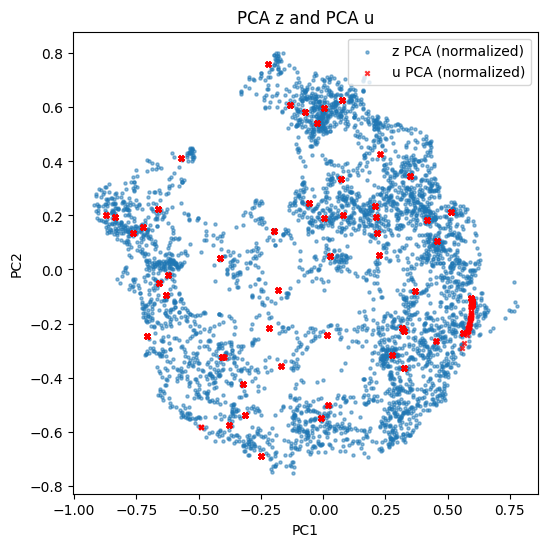

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(z_pca_norm[:, 0], z_pca_norm[:, 1], 
            s=5, alpha=0.5, label='z PCA (normalized)')
plt.scatter(u_pca_norm[:, 0], u_pca_norm[:, 1], 
            s=10, alpha=0.8, label='u PCA (normalized)', marker='x', color='red')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA z and PCA u')
plt.legend()
plt.show()